

# **Librerias**


In [ ]:
!pip install phik
!pip install xgboost

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

In [ ]:
import phik
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn import metrics
from scipy.spatial import distance
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from collections import Counter
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from xgboost import XGBRegressor

# **Carga de Datos**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/My Drive/Dataset/Manizales.csv"
df = pd.read_csv(path,delimiter=';')
df

,YEAR,DOY,T2M,T2M_RANGE,T2M_MAX,QV2M,RH2M,PRECTOTCORR,PS,WS10M,WS10M_RANGE
0,2022,1,16.38,6.44,20.56,13.12,89.62,7.76,78.83,0.77,0.73
1,2022,2,15.69,4.80,18.28,13.06,92.44,12.15,78.95,0.55,0.84
2,2022,3,15.81,8.22,20.35,12.33,87.44,6.03,79.00,0.90,1.02
3,2022,4,15.53,8.92,20.19,12.02,86.88,2.44,78.85,0.92,1.49
4,2022,5,15.54,9.25,20.67,12.57,90.12,7.07,78.67,0.99,1.22
...,...,...,...,...,...,...,...,...,...,...,...
724,2023,360,15.94,4.17,18.07,13.61,94.75,7.12,79.04,0.62,0.80
725,2023,361,16.47,7.94,20.77,13.43,90.94,2.17,79.02,0.64,1.18
726,2023,362,16.40,4.98,19.32,13.79,93.56,8.06,79.04,0.71,0.80
727,2023,363,17.17,7.78,21.95,13.31,87.06,3.28,79.13,0.74,0.87


In [ ]:
# Crear nuevas columnas basadas en las columnas necesarias por weatherapi
df['temperatura'] = df['T2M']
df['humedad'] = df['RH2M'] / 100
df['viento'] = df['WS10M']* 3.6
df['presion'] = df['PS']
df['visibilidad'] = 10 / (df['precipitacion'] + 1e-5)
df['precipitacion'] = df['PRECTOTCORR']

In [ ]:
# Seleccionar solo las columnas necesarias
weatherapi_df = df[['temperatura', 'humedad', 'viento', 'presion', 'visibilidad', 'precipitacion']]
weatherapi_df

,temperatura,humedad,viento,presion,visibilidad,precipitacion
0,16.38,0.8962,2.772,78.83,1.288658,7.76
1,15.69,0.9244,1.980,78.95,0.823045,12.15
2,15.81,0.8744,3.240,79.00,1.658372,6.03
3,15.53,0.8688,3.312,78.85,4.098344,2.44
4,15.54,0.9012,3.564,78.67,1.414425,7.07
...,...,...,...,...,...,...
724,15.94,0.9475,2.232,79.04,1.404492,7.12
725,16.47,0.9094,2.304,79.02,4.608274,2.17
726,16.40,0.9356,2.556,79.04,1.240693,8.06
727,17.17,0.8706,2.664,79.13,3.048771,3.28


In [ ]:
weatherapi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temperatura    729 non-null    float64
 1   humedad        729 non-null    float64
 2   viento         729 non-null    float64
 3   presion        729 non-null    float64
 4   visibilidad    729 non-null    float64
 5   precipitacion  729 non-null    float64
dtypes: float64(6)
memory usage: 34.3 KB


In [ ]:
weatherapi_df.describe()

,temperatura,humedad,viento,presion,visibilidad,precipitacion
count,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000
mean,16.200727,0.873938,3.484988,78.927682,2762.648116,6.093004
std,0.718648,0.037181,1.026248,0.091768,52341.342666,6.100663
min,14.050000,0.731200,1.368000,78.650000,0.270270,0.000000
25%,15.690000,0.850000,2.772000,78.870000,1.128667,1.430000
50%,16.210000,0.876200,3.384000,78.930000,2.570687,3.890000
75%,16.710000,0.899400,4.032000,78.990000,6.992958,8.860000
max,18.140000,0.980000,8.424000,79.200000,1000000.000000,37.000000


In [ ]:
# Identificar cuantos valores duplicados hay
num_duplicates = weatherapi_df.duplicated().sum()
print("Número de datos duplicados:", num_duplicates)

Número de datos duplicados: 0


In [ ]:
path = "/content/drive/My Drive/Dataset/recomendaciones.csv"
recomendaciones_df = pd.read_csv(path)
recomendaciones_df

,id,cultivo,temperatura_min,temperatura_max,humedad_min,humedad_max,condiciones,descripcion
0,77,Arroz,20,30,70,90,Soleado,El arroz necesita temperaturas cálidas y alta ...
1,78,Maíz,18,35,60,80,Parcialmente soleado,Ideal para temperaturas cálidas y humedad mode...
2,79,Café,15,25,60,85,Sombra parcial,Cultivado en zonas montañosas con sombra parcial.
3,80,Caña de azúcar,21,32,70,85,Soleado,Prefiere altas temperaturas y humedad constante.
4,81,Plátano,20,30,75,90,Soleado,Crece bien en climas cálidos y húmedos.
...,...,...,...,...,...,...,...,...
112,189,Chirimoya costeña,15,25,60,80,Parcialmente soleado,Prefiere climas frescos y húmedos.
113,190,Mamoncillo,20,30,70,90,Soleado,Crece en climas cálidos y húmedos.
114,191,Camu camu de selva baja,22,32,75,90,Soleado,Ideal en climas tropicales húmedos de selva.
115,192,Guama costeña,18,30,70,85,Soleado,Crece en climas cálidos y húmedos.


# **Graficas**

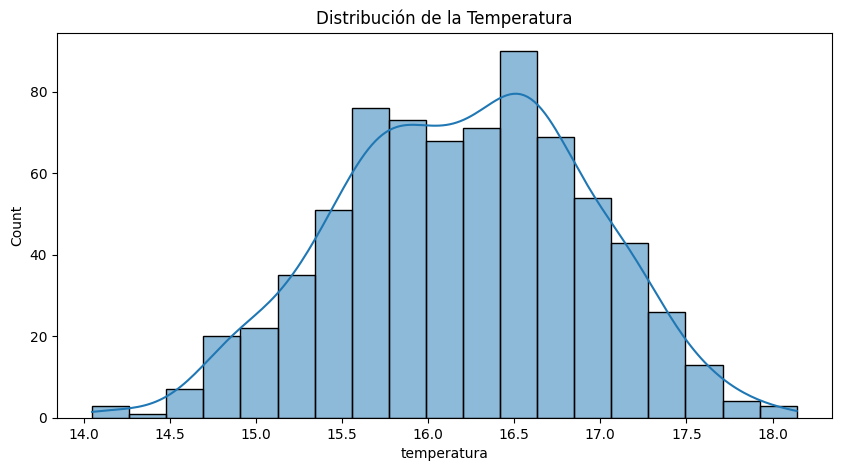

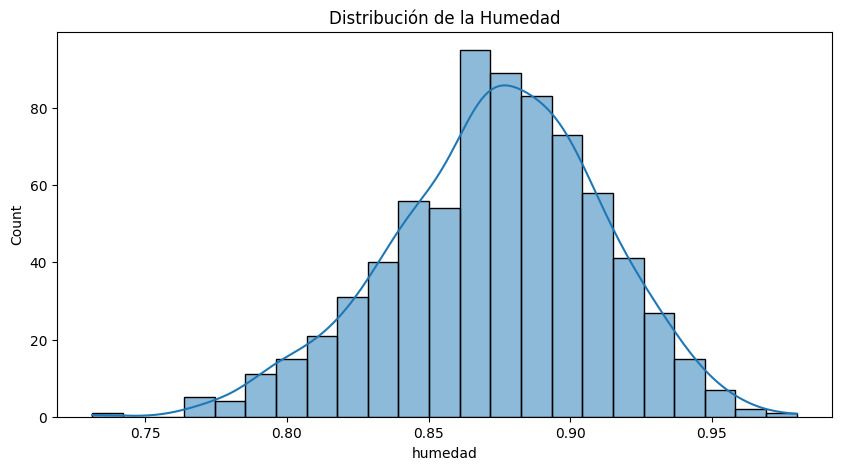

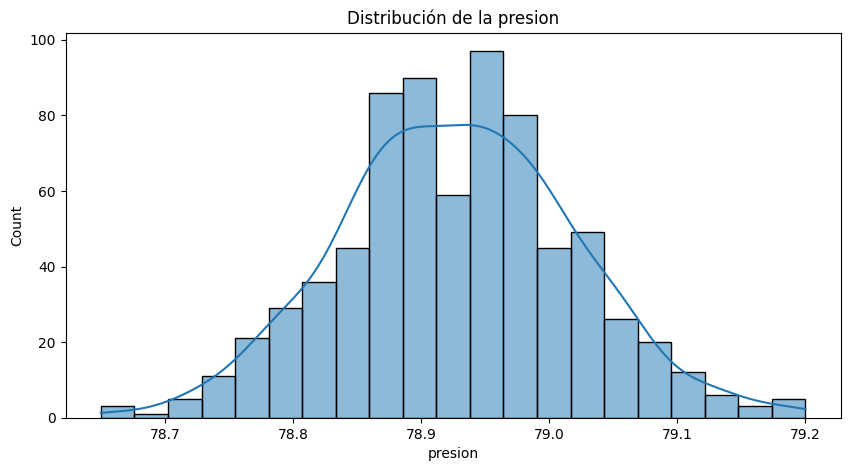

In [ ]:
# Visualizar la distribución de los datos de temperatura y humedad
plt.figure(figsize=(10,5))
sns.histplot(weatherapi_df['temperatura'], kde=True)
plt.title('Distribución de la Temperatura')
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(weatherapi_df['humedad'], kde=True)
plt.title('Distribución de la Humedad')
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(weatherapi_df['presion'], kde=True)
plt.title('Distribución de la presion')
plt.show()



# **Modelo IA**

In [ ]:
# Definir las características (X) y los objetivos (y)
X = df[['temperatura','humedad', 'viento', 'presion', 'visibilidad', 'precipitacion']]
y_temp = df['temperatura']
y_hum = df['humedad']

In [ ]:
# Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_temp_train, y_temp_test = train_test_split(X, y_temp, test_size=0.2, random_state=42)
X_train, X_test, y_hum_train, y_hum_test = train_test_split(X, y_hum, test_size=0.2, random_state=42)

In [ ]:
# Crear y entrenar el modelo de temperatura
model_temp = XGBRegressor(colsample_bytree= 1.0, learning_rate= 0.01, max_depth= 5, n_estimators= 200, subsample= 0.7)
model_temp.fit(X_train, y_temp_train)

# Hacer predicciones en el conjunto de prueba
y_temp_pred = model_temp.predict(X_test)

# Calcular el error
mae_temp = mean_absolute_error(y_temp_test, y_temp_pred)
print(f"MAE de Temperatura: {mae_temp}")

MAE de Temperatura: 0.07471221740931695


In [ ]:
# Crear y entrenar el modelo de humedad
model_hum = XGBRegressor(colsample_bytree= 1.0, learning_rate= 0.01, max_depth= 5, n_estimators= 200, subsample= 0.7)
model_hum.fit(X_train, y_hum_train)

# Hacer predicciones en el conjunto de prueba
y_hum_pred = model_hum.predict(X_test)

# Calcular el error
mae_hum = mean_absolute_error(y_hum_test, y_hum_pred)
print(f"MAE de Humedad: {mae_hum}")

MAE de Humedad: 0.0035939518183877982


In [ ]:
# Ejemplo: si tienes valores promedio o condiciones estimadas para los próximos seis meses
future_conditions = pd.DataFrame({
    'temperatura': [17.85],
    'humedad': [0.8819],  # Ejemplo de un valor de humedad promedio esperado
    'viento': [2.05],    # Ejemplo de velocidad de viento en km/h
    'presion': [79.04],  # Presión en kPa
    'visibilidad': [10],  # Visibilidad en km
    'precipitacion': [11.62]  # Precipitación en mm/día
})

# Predecir temperatura y humedad para los próximos seis meses
temp_forecast = model_temp.predict(future_conditions)
hum_forecast = model_hum.predict(future_conditions)

print(f"Predicción de Temperatura (próximos seis meses): {temp_forecast[0]} °C")
print(f"Predicción de Humedad (próximos seis meses): {hum_forecast[0] * 100} %")

Predicción de Temperatura (próximos seis meses): 17.526575088500977 °C
Predicción de Humedad (próximos seis meses): 88.08630108833313 %


In [ ]:
# Definir el modelo base
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],        # Número de árboles
    'learning_rate': [0.01, 0.1, 0.2],     # Tasa de aprendizaje
    'max_depth': [3, 5, 7],                # Profundidad máxima de los árboles
    'subsample': [0.7, 0.8, 1.0],          # Fracción de muestras para cada árbol
    'colsample_bytree': [0.7, 0.8, 1.0],   # Fracción de características para cada árbol
}

In [ ]:
# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # Puntaje basado en MAE
    cv=3,                               # Número de divisiones de validación cruzada
    verbose=1,
    n_jobs=-1                           # Usar todos los núcleos disponibles para acelerar el proceso
)

# Ajustar GridSearch en los datos de temperatura
grid_search.fit(X_train, y_temp_train)

# Mostrar los mejores parámetros
print("Mejores parámetros para la predicción de temperatura:")
print(grid_search.best_params_)
print("Mejor MAE en validación cruzada: ", -grid_search.best_score_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mejores parámetros para la predicción de temperatura:
{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.7}
Mejor MAE en validación cruzada:  0.5295349817130627


In [ ]:
# Valores de temperatura y humedad predichos
temp_pred = temp_forecast[0]  # Valor de temperatura predicho
hum_pred = hum_forecast[0]    # Valor de humedad predicho

# Filtrar cultivos cuyos rangos incluyen los valores predichos o están cercanos
recomendaciones_df['distancia'] = ((recomendaciones_df['temperatura_min'] <= temp_pred) &
                                   (recomendaciones_df['temperatura_max'] >= temp_pred) &
                                   (recomendaciones_df['humedad_min'] <= hum_pred) &
                                   (recomendaciones_df['humedad_max'] >= hum_pred))

# Si no hay cultivos que cumplan exactamente el rango, calcular la distancia en temperatura y humedad
if recomendaciones_df['distancia'].sum() == 0:
    recomendaciones_df['distancia'] = ((recomendaciones_df['temperatura_min'] - temp_pred).abs() +
                                       (recomendaciones_df['temperatura_max'] - temp_pred).abs() +
                                       (recomendaciones_df['humedad_min'] - hum_pred).abs() +
                                       (recomendaciones_df['humedad_max'] - hum_pred).abs())
    mejores_cultivos = recomendaciones_df.nsmallest(5, 'distancia')
else:
    mejores_cultivos = recomendaciones_df[recomendaciones_df['distancia']].head(5)

# Mostrar los cultivos seleccionados
print("Los 5 mejores cultivos recomendados:")
print(mejores_cultivos[['cultivo', 'temperatura_min', 'temperatura_max', 'humedad_min', 'humedad_max', 'descripcion']])

Los 5 mejores cultivos recomendados:
      cultivo  temperatura_min  temperatura_max  humedad_min  humedad_max  \
55       Chía               18               28           40           60   
87    Tomillo               15               30           40           60   
88     Romero               15               30           40           60   
95    Orégano               15               30           40           60   
62  Tamarindo               25               35           40           60   

                                descripcion  
55       Crece en climas templados y secos.  
87       Ideal para climas cálidos y secos.  
88  Prefiere zonas áridas con baja humedad.  
95         Ideal en climas cálidos y secos.  
62         Crece en climas cálidos y secos.  


# **Comparacion**

In [ ]:
path = "/content/drive/My Drive/Dataset/Manizales2024.csv"
climaActual = pd.read_csv(path,delimiter=';')
climaActual

,temperatura,humedad
0,17.19,88.19
1,17.85,86.50
2,17.47,85.88
3,17.25,85.00
4,17.13,84.62
...,...,...
148,17.33,86.81
149,16.74,89.81
150,17.12,88.12
151,17.57,86.00


**gráfico de líneas**

Comparan las temperaturas y las humididades promedio reales con las predicciones para los meses de enero a junio de 2024.




<ipython-input-165-d3e4a31bde43>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  promedio_mensual = climaActual.resample('M').mean()


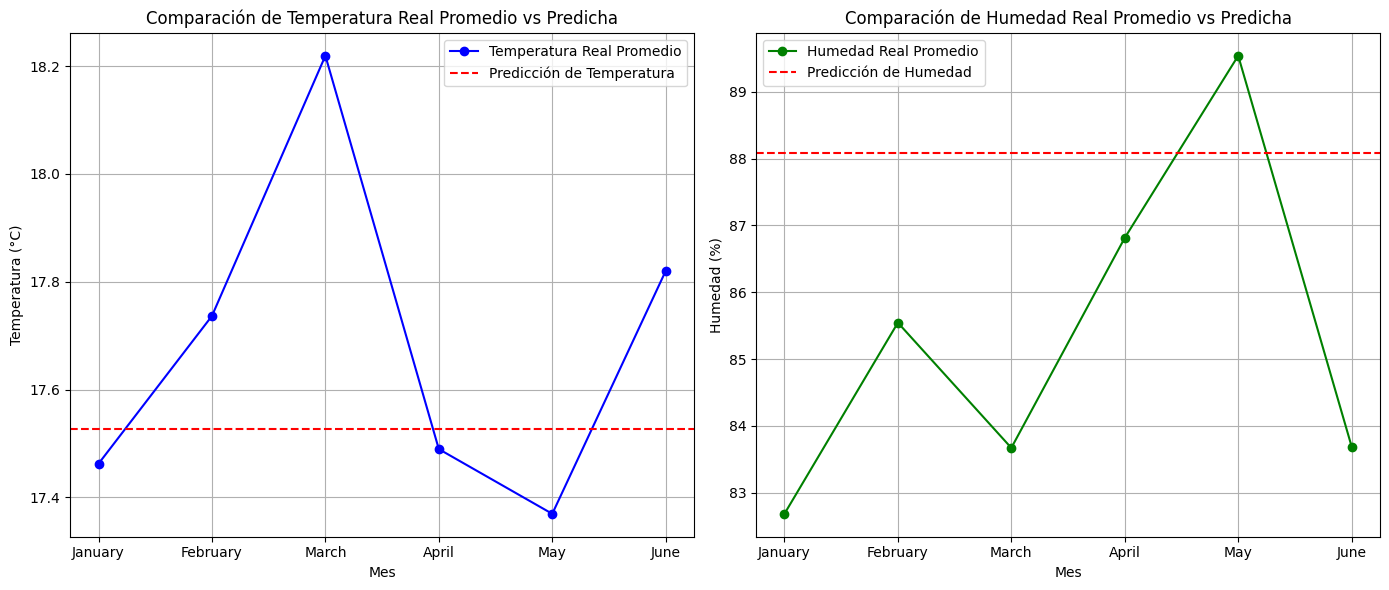

In [ ]:
# Crear un índice de fechas ficticias para los datos (supongamos que comienzas el 1 de enero)
climaActual['fecha'] = pd.date_range(start='2024-01-01', periods=len(climaActual), freq='D')

# Establecer la columna de fecha como índice
climaActual.set_index('fecha', inplace=True)

# Calcular el promedio mensual
promedio_mensual = climaActual.resample('M').mean()

# Crear los nombres de los meses para la gráfica
meses_nombres = promedio_mensual.index.strftime('%B')

# Graficar los datos de temperatura y humedad promedio
plt.figure(figsize=(14, 6))

# Gráfico de temperatura
plt.subplot(1, 2, 1)
plt.plot(meses_nombres, promedio_mensual['temperatura'], marker='o', label='Temperatura Real Promedio', color='blue')
plt.axhline(y=temp_forecast[0], color='red', linestyle='--', label='Predicción de Temperatura')
plt.xlabel("Mes")
plt.ylabel("Temperatura (°C)")
plt.title("Comparación de Temperatura Real Promedio vs Predicha")
plt.legend()
plt.grid()

# Gráfico de humedad
plt.subplot(1, 2, 2)
plt.plot(meses_nombres, promedio_mensual['humedad'] , marker='o', label='Humedad Real Promedio', color='green')  # Multiplicamos por 100 para convertir a porcentaje
plt.axhline(y=hum_forecast[0]* 100, color='red', linestyle='--', label='Predicción de Humedad')
plt.xlabel("Mes")
plt.ylabel("Humedad (%)")
plt.title("Comparación de Humedad Real Promedio vs Predicha")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


**Gráfico de Dispersión**

Este gráfico mostrará la relación entre las temperaturas reales promedio y las predicciones de temperatura.

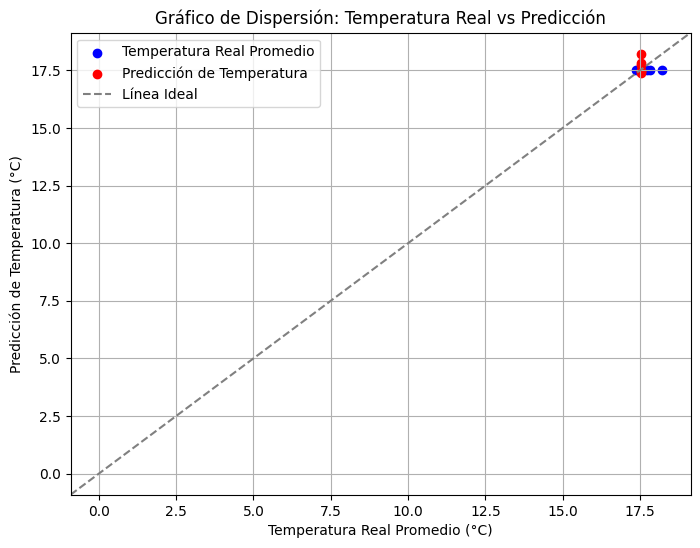

In [ ]:
# Gráfico de dispersión para la temperatura
plt.figure(figsize=(8, 6))
plt.scatter(promedio_mensual['temperatura'], [temp_forecast[0]] * len(promedio_mensual), color='blue', label='Temperatura Real Promedio')
plt.scatter([temp_forecast[0]] * len(promedio_mensual), promedio_mensual['temperatura'], color='red', label='Predicción de Temperatura')
plt.xlabel("Temperatura Real Promedio (°C)")
plt.ylabel("Predicción de Temperatura (°C)")
plt.title("Gráfico de Dispersión: Temperatura Real vs Predicción")
plt.axline((0, 0), slope=1, color='gray', linestyle='--', label='Línea Ideal')
plt.legend()
plt.grid()
plt.show()

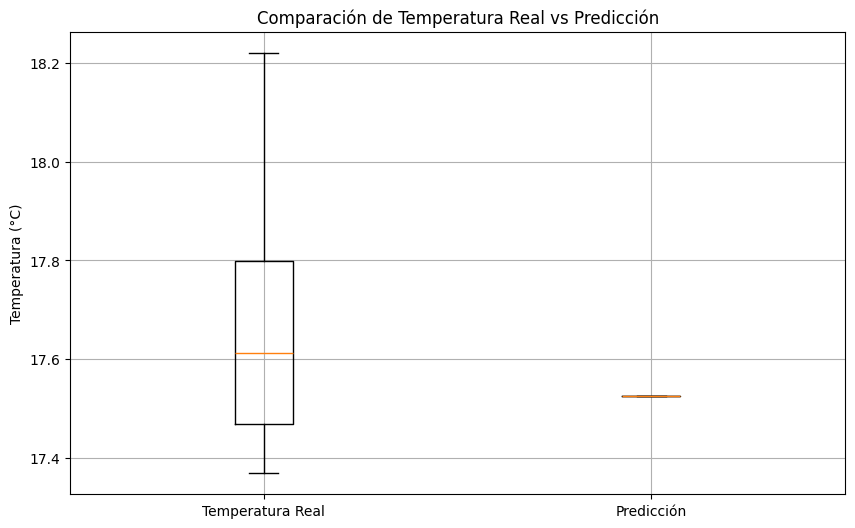

In [ ]:
# Box plot de temperatura
plt.figure(figsize=(10, 6))
data = [promedio_mensual['temperatura'], [temp_forecast[0]] * len(promedio_mensual)]
plt.boxplot(data, labels=['Temperatura Real', 'Predicción'])
plt.ylabel('Temperatura (°C)')
plt.title('Comparación de Temperatura Real vs Predicción')
plt.grid()
plt.show()

Un gráfico que muestra las series temporales de temperatura y humedad, destacando las predicciones.

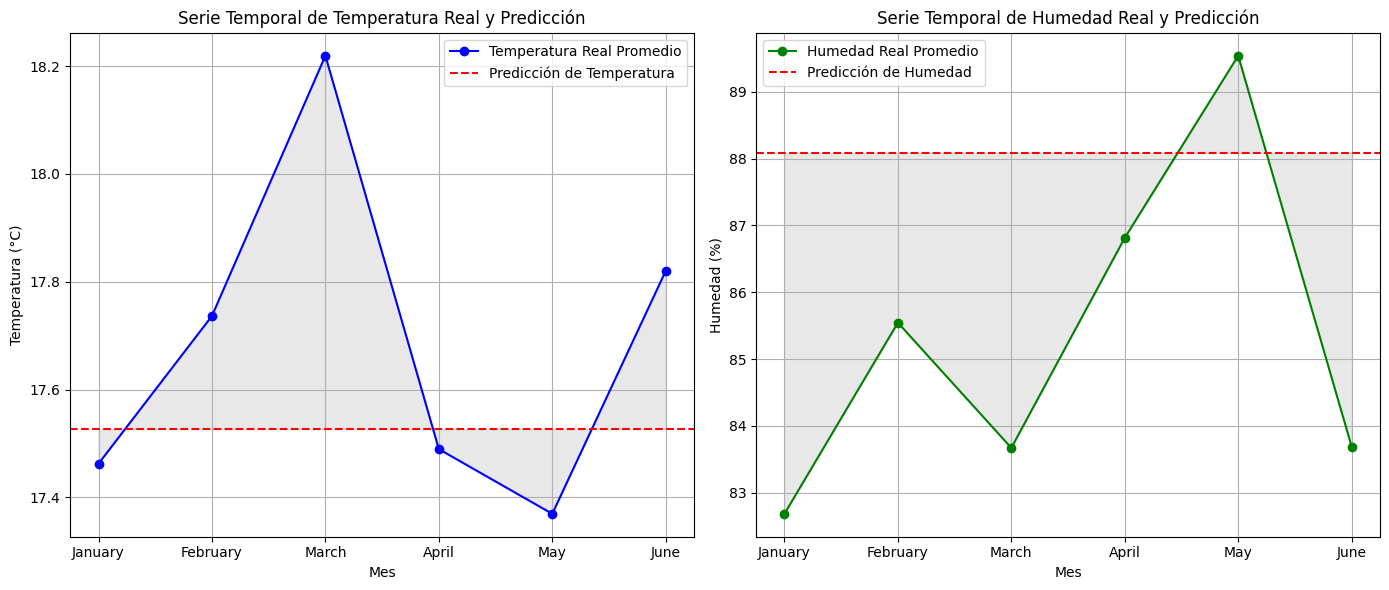

In [ ]:
plt.figure(figsize=(14, 6))

# Gráfico de temperatura
plt.subplot(1, 2, 1)
plt.plot(meses_nombres, promedio_mensual['temperatura'], marker='o', label='Temperatura Real Promedio', color='blue')
plt.axhline(y=temp_forecast[0], color='red', linestyle='--', label='Predicción de Temperatura')
plt.fill_between(meses_nombres, promedio_mensual['temperatura'], temp_forecast[0], color='lightgray', alpha=0.5)
plt.xlabel("Mes")
plt.ylabel("Temperatura (°C)")
plt.title("Serie Temporal de Temperatura Real y Predicción")
plt.legend()
plt.grid()

# Gráfico de humedad
plt.subplot(1, 2, 2)
plt.plot(meses_nombres, promedio_mensual['humedad'] , marker='o', label='Humedad Real Promedio', color='green')
plt.axhline(y=hum_forecast[0] * 100, color='red', linestyle='--', label='Predicción de Humedad')
plt.fill_between(meses_nombres, promedio_mensual['humedad'] , hum_forecast[0] * 100, color='lightgray', alpha=0.5)
plt.xlabel("Mes")
plt.ylabel("Humedad (%)")
plt.title("Serie Temporal de Humedad Real y Predicción")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()